In [16]:
import pandas as pd
import numpy as np
from pygobnilp.gobnilp import Gobnilp
import pgmpy
import itertools
from pgmpy.estimators.CITests import log_likelihood
from pgmpy.estimators.CITests import chi_square
import time

In [17]:
def csv_format_discrete(csv_file):
    df = pd.read_csv(csv_file, sep="\s+")
    return df.drop([0])

#returns the csv_file in a pandas dataframe, formatted properly, discrete dataset only

In [21]:
#small network : n <= 20 nodes, medium network: 20 <= n <= 50 , large: 50 <= n <= 100, ... 
df_small = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\asia_10000.dat")
df_medium = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\alarm_100.dat")
# df_large = csv_format_discrete(r"")

### chi-squared test

In [22]:
#0th order chi2 test
def chi2bool(df, rho):
    '''
    0th order CI test
    
    Parameters:
    df -> pandas dataframe
    rho -> significance level, only accept 0 <= rho <= 1.0
    '''
    chi2 = []
    v = list(df)
    my_list = list(itertools.combinations(v,2))
    y_0, y_1 = [x[0] for x in my_list], [x[1] for x in my_list]
    for i,j in zip(y_0, y_1):
        chi = chi_square(X=i, Y=j, Z=[], data=df, significance_level=rho)
        chi2.append((i,j,chi))
    true_0 = [x for x in chi2 if True in x]
    false_0 = [x for x in chi2 if False in x]
    return true_0, false_0

### Pearson's Product Moment Correlation Coefficient

In [23]:
df_gaus = pd.read_csv(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\gaussian.dat", sep="\s+")
df_gaus

,A,B,C,D,E,F,G
0,1.113083,1.932164,7.074806,8.660411,0.881591,24.719501,9.216382
1,-0.247948,11.334343,24.347372,23.355432,7.040113,36.812996,3.678833
2,1.854508,3.032020,11.086473,11.055891,3.834530,22.017182,2.424513
3,0.833911,3.857970,11.224775,11.937471,1.005624,23.285643,6.085473
4,0.488614,4.512613,10.000476,12.537179,4.084746,24.537596,5.117575
...,...,...,...,...,...,...,...
4995,0.625860,1.587941,5.952431,8.516822,4.894385,16.950123,2.558535
4996,0.241723,-0.497071,1.695681,5.563204,7.454081,21.165266,4.867241
4997,2.527720,-2.706339,0.984988,1.597447,3.692427,18.808892,5.598200
4998,1.484585,1.468603,7.206672,8.486116,2.611856,21.528922,5.106188


In [24]:
np.corrcoef(x=df_gaus['A'], y=df_gaus['B'])

array([[ 1.        , -0.02611659],
       [-0.02611659,  1.        ]])

### Sorting Functions

In [25]:
def create_permutations(my_list):
    '''
    takes in a list, remove extra permutations from the list and only creates a pair of permutations
    '''
    p_permutations = []
    new_list = list(set(tuple(sorted(l[:2])) for l in my_list))
    for items in new_list:
        new_list_0 = list(itertools.permutations(items[:2],2))[1]
        p_permutations.append(new_list_0)
    return new_list + p_permutations

In [26]:
#given 2 lists, append them together and remove duplicates
def remove_permutations(list_):
    '''
    returns a sorted list without permutation
    '''
    return sorted(list(set(tuple(sorted(l[:2])) for l in list_)))

### 1st order CI

In [27]:
#1st order CI
def cond_1_generate(df, rho):
    v = list(df)
    p_permutations = list(itertools.permutations(v,3))
    order_0 = create_permutations(chi2bool(df, rho)[0])
    generated = [x for x in p_permutations if x[:2] not in order_0]
    generated_0 = set(tuple(sorted(items[:2])) for items in generated)
    generate_return = [x for x in generated if x[:2] in generated_0]
    return generate_return

In [28]:
def cond_1_test(df, rho):
    chi2_data = []
    phi = cond_1_generate(df, rho)
    for i,j,k in phi:
        chi2 = chi_square(X=i, Y=j, Z=[k], data=df, significance_level=rho)
        chi2_data.append((i,j,k,chi2))
    true_list = [x for x in chi2_data if True in x]
    false_list = [x for x in chi2_data if False in x]
    return true_list, false_list

### CONDITIONAL MAIN CODE

In [29]:
def PC(df, n, rho):
    '''
    Note:
    This function will start from at least 0th order CI
    
    Parameters:
    df (pandas dataframe)
    n, an integer, the stopping point of the while loop
    rho (the significance level, only accepts values between 0 and 1 inclusive)
    
    Returns:
    A list which contains every independent X and Y
    '''
    N = 3
    v = list(df)
    # remove_list = [x for x in p_permute]
    remove_list = create_permutations([x[:2] for x in chi2bool(df, rho)[0]])
    #x[:2] for 0th order and its permutations, so we can later remove it 
    empty_list = []
    while N <= n:
        list_permutations = [x for x in itertools.permutations(v, N) if x[:2] not in remove_list]
        p_1 = [x[:1] for x in list_permutations]
        p_2 = [x[1:2] for x in list_permutations]
        p = [x[2:] for x in list_permutations]
        for i,j,k in zip(p_1, p_2, p):
            chi2 = chi_square(X=i[0], Y=j[0], Z=k, data=df, significance_level=rho)
            empty_list.append((i[0],j[0],k,chi2))
        true_list = create_permutations([x[:2] for x in empty_list if True in x])
        #create_permutations ensures only 1 set of permutations of (X,Y) and (Y,X) and removes dupes
        remove_list = remove_list + create_permutations(true_list)
        remove_list = create_permutations(remove_list)
        N += 1
        
    return remove_permutations(remove_list) #returns 1 set of permutations

#ON MEDIUM SIZED NETWORKS:
#nP3 takes 2minutes to run
#nP4 takes 9-15minutes to run
#nP5 takes ??? minutes to run
#nP6 not doable

In [56]:
tic = time.time()
n_edges = []
for i in np.linspace(0.0, 0.3, 7):
    n_ = PC(df_medium, 3, i)
    print(i, len(n_))
    n_edges.append((i, len(n_)))
                   
toc = time.time()

0.0 666
0.049999999999999996 635
0.09999999999999999 631
0.15 623
0.19999999999999998 623
0.24999999999999997 621
0.3 618


In [57]:
time_taken = toc - tic
time_taken

390.80788254737854

In [50]:
import matplotlib.pyplot as plt

In [58]:
v_0 = [x[0] for x in n_edges]
v_1 = [x[1] for x in n_edges]
v_1

[666, 635, 631, 623, 623, 621, 618]

In [66]:
len(list(df_medium))

37

Text(0, 0.5, 'number of edges removed')

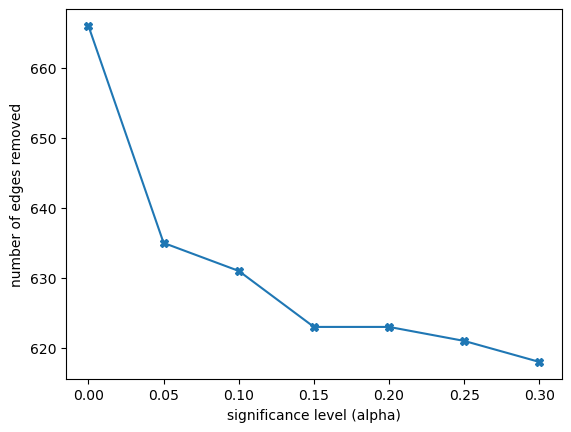

In [68]:
plt.plot(v_0, v_1, marker='X')
plt.xlabel('significance level (alpha)')
plt.ylabel('number of edges removed')
#666 makes sense because 37C2 = 666

In [11]:
%%time
y0 = PC(df, 3, 0.05)

CPU times: total: 3min 12s
Wall time: 3min 19s


### small network

In [33]:
m = Gobnilp()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-21
Set parameter PreCrush to value 1
Set parameter CutPasses to value 100000
Set parameter GomoryPasses to value 100000
Set parameter MIPFocus to value 2
Set parameter ZeroHalfCuts to value 2
Set parameter MIPGap to value 0
Set parameter MIPGapAbs to value 0


**********
BN has score -22466.396546491495
**********
Eight<-Six,Three -4150.291729106073
Six<-Five,Two -5.611578690688475
Three<- -6901.1493808303785
Five<-Four -633.8404777927353
Four<- -527.7536882896093
One<-Three -6460.081285708176
Seven<-Six -1881.452188461728
Two<-One -1906.2162176121055
**********
bnlearn modelstring = 
[Eight|Six:Three][Six|Two:Five][Three][Five|Four][Four][One|Three][Seven|Six][Two|One]
**********
CPDAG:
Vertices: Eight,Six,Three,Five,Four,One,Seven,Two
Six->Eight
Six->Seven
Three->Eight
Three-One
Five->Six
Four-Five
One-Two
Two->Six



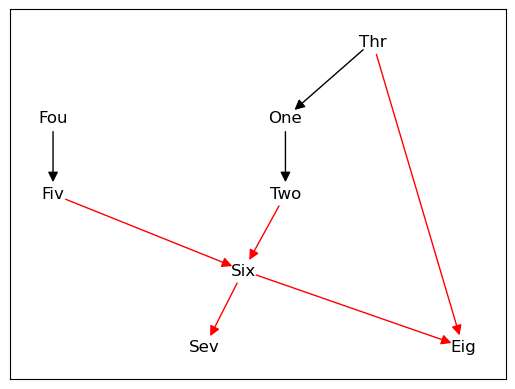

CPU times: total: 4.19 s
Wall time: 4.07 s


In [35]:
%%time
m.learn(r'C:\Users\User\Documents\GitHub\ML_FYP\dataset\asia_10000.dat')

In [41]:
y_small = PC(df_small, 3, 0.05)

In [37]:
for i,j in y_asia:
        m.add_obligatory_independence([i],[j])

**********
BN has score -22466.396546491495
**********
Eight<-Six,Three -4150.291729106073
Six<-Five,Two -5.611578690688475
Three<- -6901.1493808303785
Five<-Four -633.8404777927353
Four<- -527.7536882896093
One<-Three -6460.081285708176
Seven<-Six -1881.452188461728
Two<-One -1906.2162176121055
**********
bnlearn modelstring = 
[Eight|Six:Three][Six|Two:Five][Three][Five|Four][Four][One|Three][Seven|Six][Two|One]
**********
CPDAG:
Vertices: Eight,Six,Three,Five,Four,One,Seven,Two
Six->Eight
Six->Seven
Three->Eight
Three-One
Five->Six
Four-Five
One-Two
Two->Six



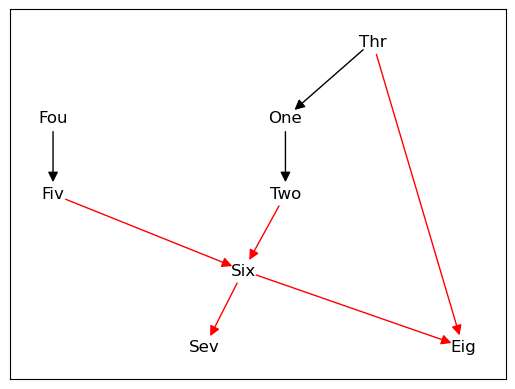

CPU times: total: 297 ms
Wall time: 387 ms


In [38]:
%%time
m.learn(start='MIP solution')

### medium-sized network

In [39]:
m = Gobnilp()

Set parameter PreCrush to value 1
Set parameter CutPasses to value 100000
Set parameter GomoryPasses to value 100000
Set parameter MIPFocus to value 2
Set parameter ZeroHalfCuts to value 2
Set parameter MIPGap to value 0
Set parameter MIPGapAbs to value 0


**********
BN has score -1349.2274186560155
**********
Eight<-Six -48.02288071683779
Six<- -69.10334937651754
Eighteen<- -114.84864901676843
Eleven<-Four,Nine,One -44.97911452065159
Nine<-Eight -54.45803624535705
One<-Eight,Ten -4.268261513555785
Four<-One,Ten -21.730285019156838
Fifteen<- -37.18499768682693
Five<-Six,Thirteen,TwentyThree -20.200035333237963
TwentyThree<-Seventeen,ThirtySix,TwentySeven -48.97474871711532
Thirteen<-Eleven,TwentyOne,TwentyTwo -18.001271852931694
Ten<- -30.411803457824988
Fourteen<-Ten,Thirteen,TwentyFour -16.161465581650788
TwentyFour<-TwentyFive,TwentySeven -6.517130360384158
Nineteen<-Eighteen,One,Sixteen -17.5534622356339
Sixteen<-Eleven -29.91614912557563
Seven<-Eight,Six,TwentyEight -14.504697864948241
TwentyEight<-Twenty,TwentySeven -42.5552595253985
Seventeen<-Eighteen -17.0741477185569
TwentyTwo<-Three,Twenty -45.66257131044179
TwentyOne<-Nineteen,TwentyTwo -9.148246913140895
Thirty<-Nine,Sixteen -16.91092107259027
ThirtyFive<-TwentyFour -8.85415

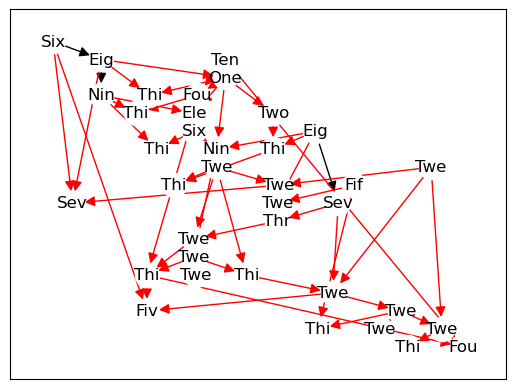

CPU times: total: 14.1 s
Wall time: 10.4 s


In [40]:
%%time
m.learn(r'C:\Users\User\Documents\GitHub\ML_FYP\dataset\alarm_100.dat')

In [43]:
%%time 
y_medium = PC(df_medium, 3, 0.05)

CPU times: total: 1min 27s
Wall time: 1min 28s


In [44]:
for i,j in y_medium:
        m.add_obligatory_independence([i],[j])

**********
BN has score -1349.2274186560155
**********
Eight<-Six -48.02288071683779
Six<- -69.10334937651754
Eighteen<- -114.84864901676843
Eleven<-Four,Nine,One -44.97911452065159
Nine<-Eight -54.45803624535705
One<-Eight,Ten -4.268261513555785
Four<-One,Ten -21.730285019156838
Fifteen<- -37.18499768682693
Five<-Six,Thirteen,TwentyThree -20.200035333237963
TwentyThree<-Seventeen,ThirtySix,TwentySeven -48.97474871711532
Thirteen<-Eleven,TwentyOne,TwentyTwo -18.001271852931694
Ten<- -30.411803457824988
Fourteen<-Ten,Thirteen,TwentyFour -16.161465581650788
TwentyFour<-TwentyFive,TwentySeven -6.517130360384158
Nineteen<-Eighteen,One,Sixteen -17.5534622356339
Sixteen<-Eleven -29.91614912557563
Seven<-Eight,Six,TwentyEight -14.504697864948241
TwentyEight<-Twenty,TwentySeven -42.5552595253985
Seventeen<-Eighteen -17.0741477185569
TwentyTwo<-Three,Twenty -45.66257131044179
TwentyOne<-Nineteen,TwentyTwo -9.148246913140895
Thirty<-Nine,Sixteen -16.91092107259027
ThirtyFive<-TwentyFour -8.85415

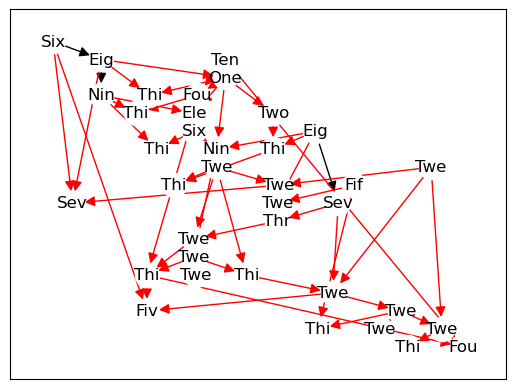

CPU times: total: 891 ms
Wall time: 1.09 s


In [46]:
%%time
m.learn(start='MIP solution')